In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data = tf.data.Dataset.list_files('/kaggle/input/animefacedataset/images/*.jpg')

In [3]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    
    img = tf.image.resize(img, size=(64, 64))
    img = img / 255.0
    
    return img

# **Loading an image**

(64, 64, 3)



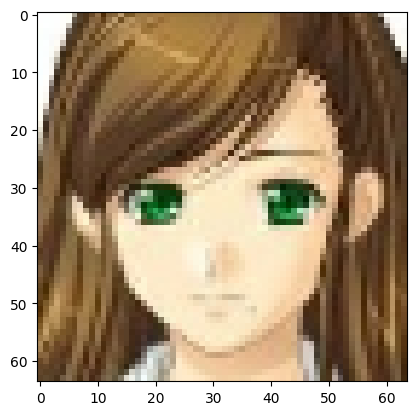

In [4]:
img1 = data.as_numpy_iterator().next()
img1 = load_image(img1)
print(img1.shape)
print()

plt.imshow(img1)
plt.show()

# **Loading the dataset**

In [5]:
data = data.map(load_image)
data = data.cache()
data = data.batch(128)
data = data.prefetch(tf.data.AUTOTUNE)
data_iterator = data.as_numpy_iterator()

In [6]:
data_iterator.next().shape

(128, 64, 64, 3)

# **Visualize data**

In [7]:
def show_images(images):
    fig, ax = plt.subplots(nrows=4, ncols=8, figsize=(20, 10))
    
    idx = 0
    for row in range(4):
        for col in range(8):
            ax[row][col].imshow(images[idx])
            ax[row][col].axis('off')
            
            idx += 1
            
    fig.tight_layout()

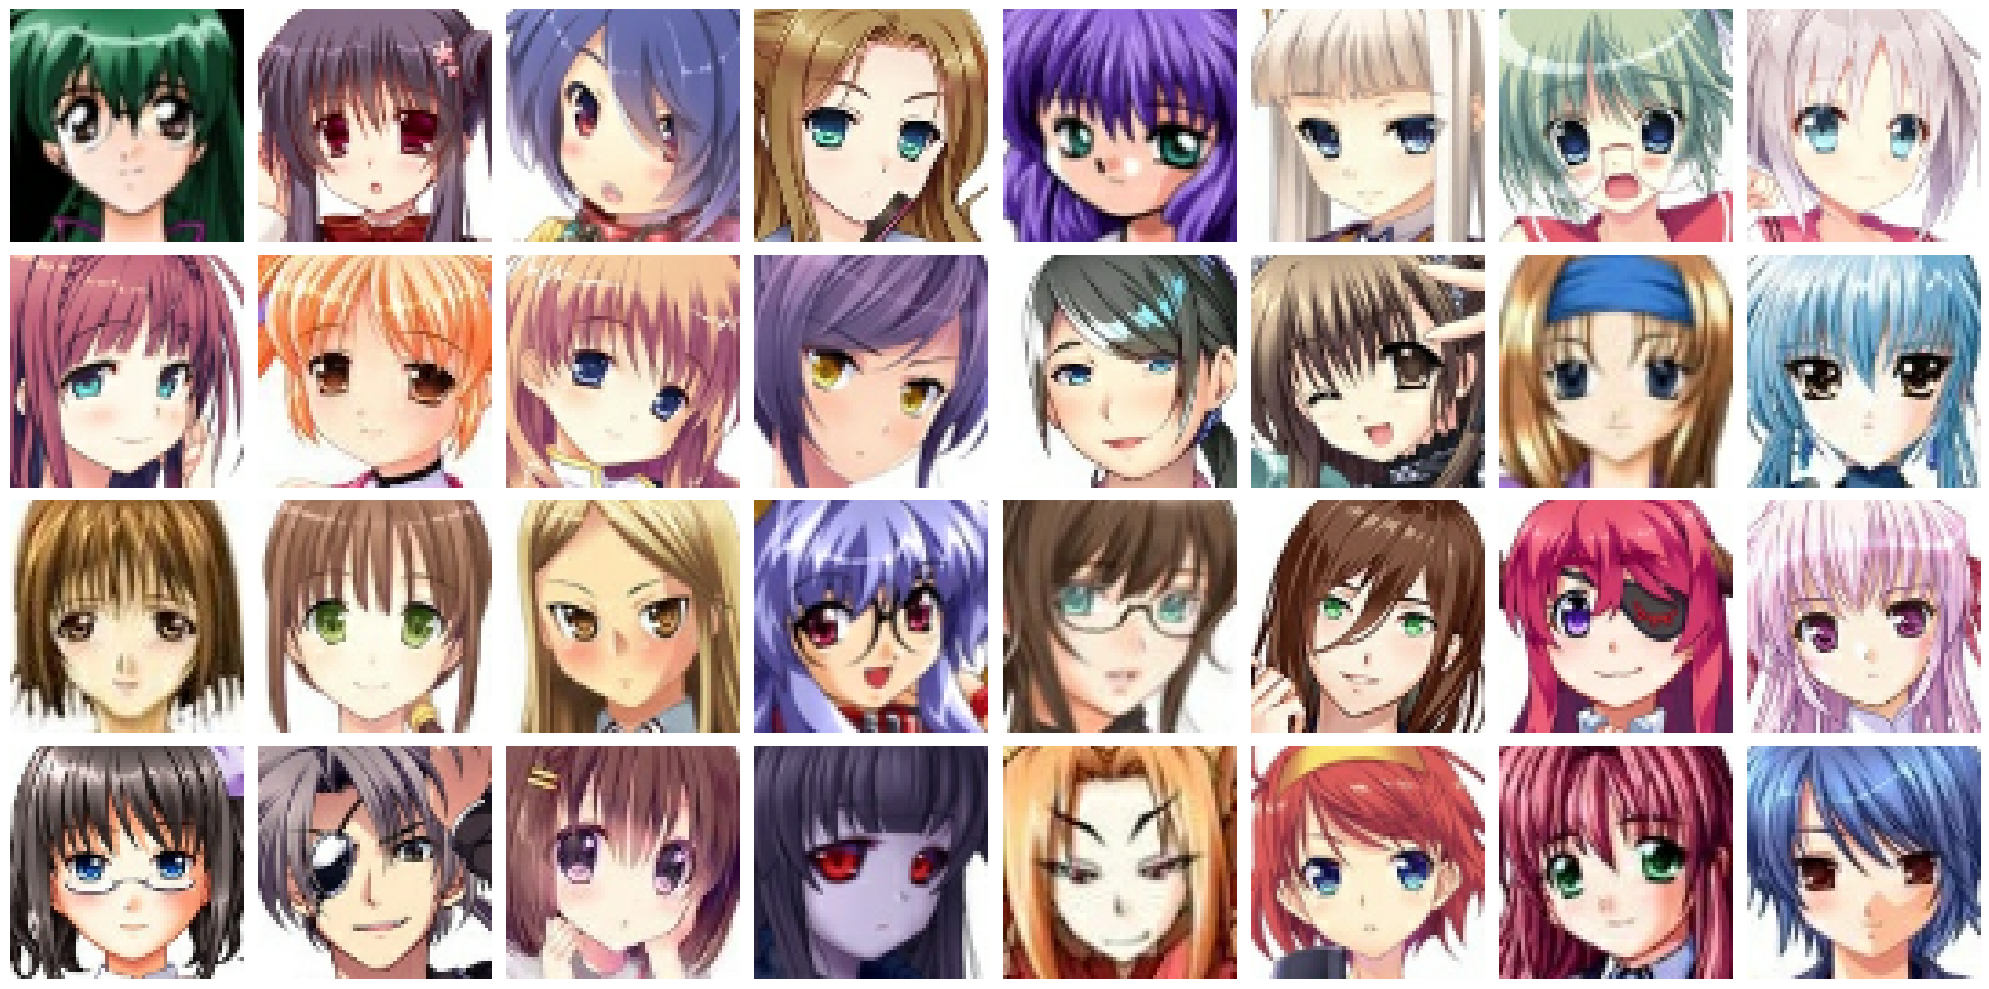

In [8]:
images = data_iterator.next()
show_images(images)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, BatchNormalization, Dense, Flatten, Reshape, LeakyReLU

# **Build generator**

In [10]:
def build_generator():
    model = Sequential(name='generator')

    model.add(Dense(4*4*128, input_shape=(128,)))
    model.add(Reshape((4,4,128)))
    
    model.add(Conv2DTranspose(512, (4,4), 2, padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(256, (4,4), 2, padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(128, (4,4), 2, padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(64, (4,4), 2, padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer='random_uniform'))
    model.add(BatchNormalization())
    
    model.add(Conv2DTranspose(3, (4,4), 1, padding='same', activation='sigmoid', kernel_initializer='random_uniform'))
    return model


In [11]:
generator = build_generator()

In [12]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        1049088   
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 256)      2097408   
 ranspose)                                                       
                                                         

# **Testing generator**

(128, 64, 64, 3)



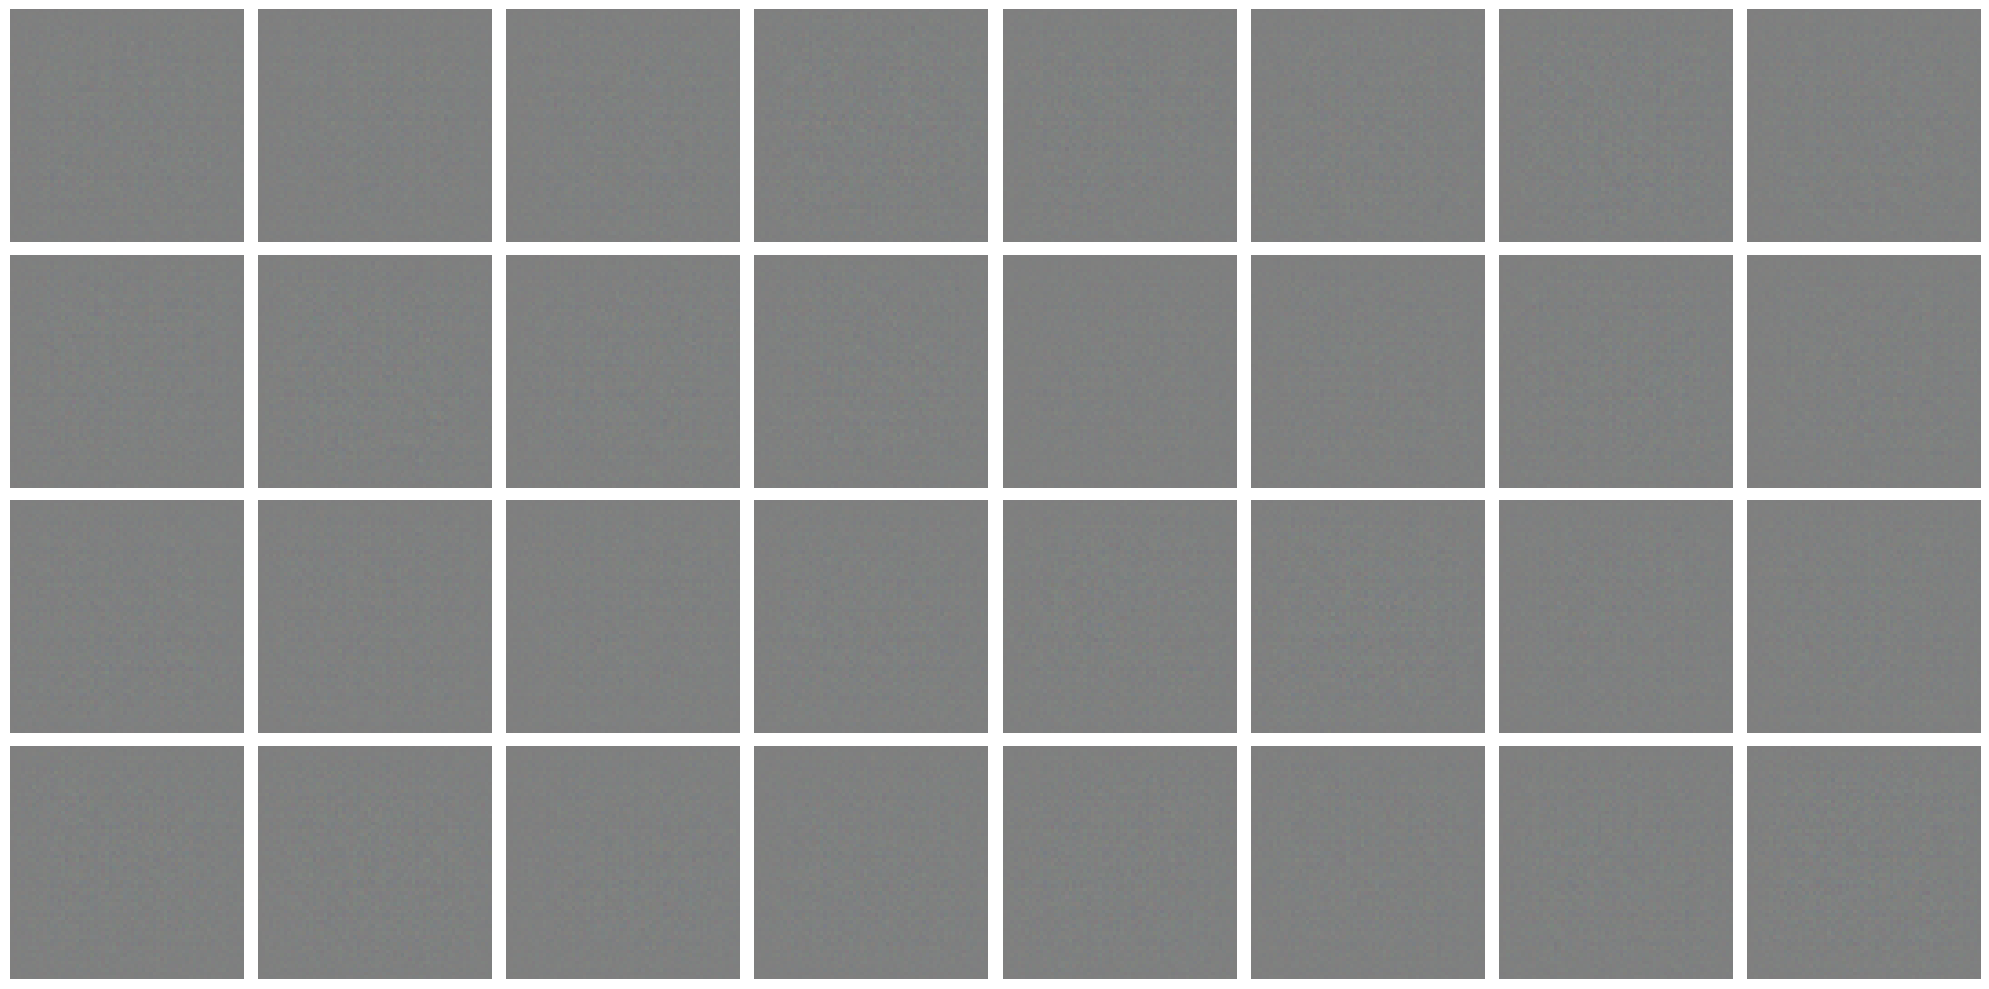

In [13]:
img1 = generator.predict(np.random.randn(128, 128), verbose=0)
print(img1.shape)
print()
show_images(img1)

# **Build discriminator**

In [14]:
def build_discriminator():
    model = Sequential(name='discriminator')

    model.add(Conv2D(32, (4,4), 1, input_shape=(64,64,3)))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(64, (4,4), 1, activation=LeakyReLU(alpha=0.2), kernel_initializer='he_normal'))
    model.add(Conv2D(64, (4,4), 1, activation=LeakyReLU(alpha=0.2), kernel_initializer='he_normal'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(64, (4,4), 1, activation=LeakyReLU(alpha=0.2), kernel_initializer='he_normal'))
    model.add(Conv2D(64, (4,4), 1, activation=LeakyReLU(alpha=0.2), kernel_initializer='he_normal'))
    model.add(Conv2D(128, (4,4), 1, activation=LeakyReLU(alpha=0.2), kernel_initializer='he_normal'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    model.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [15]:
discriminator = build_discriminator()

In [16]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        32832     
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        65600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 64)        

# **Construct training loop**

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [18]:
g_opt = Adam(learning_rate=0.00015)
d_opt = Adam(learning_rate=0.0002)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [19]:
from tensorflow.keras.models import Model

In [20]:
class AnimeGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
    
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)
        
        # Discriminator training
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y, yhat)
            
        d_grad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grad, self.discriminator.trainable_variables))
        
        # Generator training
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128)), training=True)
            
            predicted_labels = self.discriminator(gen_images, training=False)
            
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        
        g_grad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))
        
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [21]:
animeGAN = AnimeGAN(generator, discriminator)
animeGAN.compile(g_opt, d_opt, g_loss, d_loss)

# **Callback**

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
checkpoint_filepath = 'model_checkpoint_epoch_{epoch:02d}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    period=10,  # Save every 10 epochs
    save_best_only=False
)

# **Train the model**

In [24]:
NUM_EPOCHS = 100

In [25]:
hist = animeGAN.fit(data, epochs=NUM_EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/100
497/497 [==============================] - 211s 399ms/step - d_loss: 0.2968 - g_loss: 0.2243
Epoch 2/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4221 - g_loss: 1.5473
Epoch 3/100
497/497 [==============================] - 117s 236ms/step - d_loss: 0.4473 - g_loss: 1.5251
Epoch 4/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4554 - g_loss: 1.5251
Epoch 5/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4414 - g_loss: 1.7740
Epoch 6/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4536 - g_loss: 1.6542
Epoch 7/100
497/497 [==============================] - 117s 236ms/step - d_loss: 0.4667 - g_loss: 1.6194
Epoch 8/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4604 - g_loss: 1.7046
Epoch 9/100
497/497 [==============================] - 118s 237ms/step - d_loss: 0.4347 - g_loss: 1.7817
Epoch 10/100
497/497 [==============================] -

# **Generate faces**

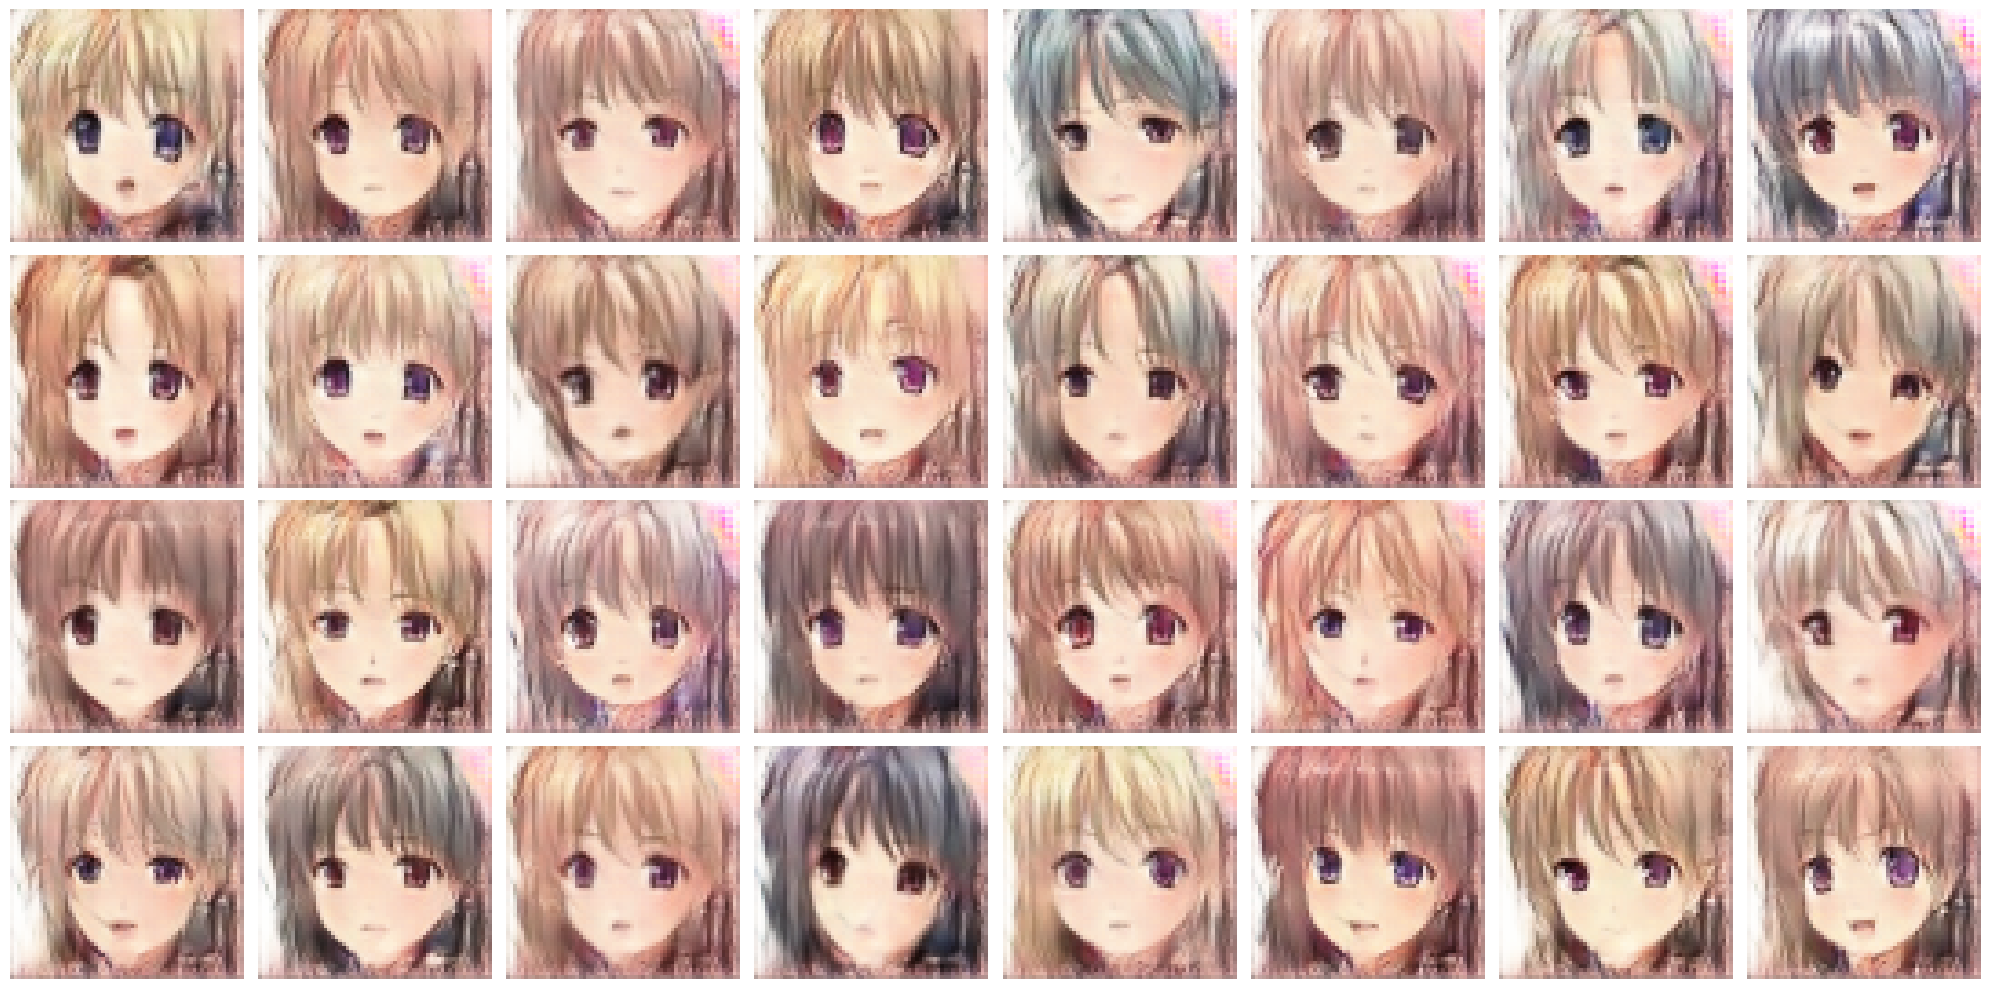

In [26]:
images = generator.predict(tf.random.uniform((32,128)),verbose=0)
show_images(images)